<a href="https://colab.research.google.com/github/fabiormazza/IA025_2022S1/blob/main/ex06/fabio_mazza/Aula_6_Exerc%C3%ADcio_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [77]:
nome = 'Fabio Renato Zocal Mazza'

print(f'Meu nome é {nome}')

Meu nome é Fabio Renato Zocal Mazza


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [78]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [79]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [80]:
batch_size = 50

## Download do CIFAR-10

In [81]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [82]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [83]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [84]:
x_test, y_test = next(iter(val_dataloader))
print(y_test)

tensor([4, 9, 5, 2, 8, 4, 1, 1, 7, 2, 9, 5, 1, 0, 2, 4, 6, 2, 5, 2, 2, 7, 8, 5,
        9, 4, 4, 0, 8, 1, 6, 8, 4, 1, 5, 7, 0, 0, 5, 0, 0, 4, 2, 1, 3, 9, 8, 3,
        4, 8])


## Implementando o Bloco Básico da Resnet

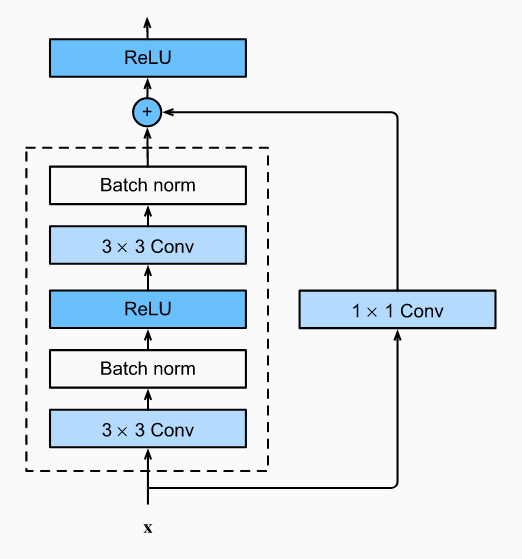

In [85]:
from torch import nn
from torch import Tensor
import torch.nn.functional as F


class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x: Tensor) -> Tensor:
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)

        res = self.downsample(x)

        #print('out:', out.shape, '\n','res:', res.shape)

        out = F.relu(out + res)

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [86]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.9070, 0.5393, 0.0000],
          [0.0000, 0.6675, 0.0000],
          [0.0000, 0.0412, 0.0000]],

         [[0.9538, 2.2488, 0.0000],
          [0.2353, 0.0000, 0.8367],
          [0.0000, 0.0000, 0.0000]],

         [[1.0948, 1.8214, 1.6990],
          [0.0000, 0.0000, 0.7841],
          [1.2312, 0.0000, 0.9162]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.9070, 0.5393, 0.0000],
          [0.0000, 0.6675, 0.0000],
          [0.0000, 0.0412, 0.0000]],

         [[0.9538, 2.2488, 0.0000],
          [0.2353, 0.0000, 0.8367],
          [0.0000, 0.0000, 0.0000]],

         [[1.0948, 1.8214, 1.6990],
          [0.0000, 0.0000, 0.7841],
          [1.2312, 0.0000, 0.9162]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [87]:
class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        
        self.model = nn.Sequential(
            MyBasicBlock(inplanes=3, planes=16, stride=1),
            MyBasicBlock(inplanes=16, planes=32, stride=1),
            MyBasicBlock(inplanes=32, planes=128, stride=1),
            nn.MaxPool2d(4)
        )
        self.len = 128 * 8 * 8
        self.outlen = 10
        self.linear = nn.Linear(self.len, self.outlen)
        
    def forward(self, x):
      out = self.model(x)
      out = out.view(-1, self.len)
      out = self.linear(out)    

      return out

## Treinamento

### Definição dos hiperparâmetros

In [88]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [132]:
def evaluation(model, loader):
    y_hat = []
    mean_accuracy = 0

    for x_eval, y_eval in loader:
      x_eval = x_eval.to(device)
      y_eval = y_eval.to(device)
      #y_hat = torch.cat((y_hat, torch.argmax(torch.nn.functional.softmax(model(x)), dim=1)), dim=0)
      y_hat = torch.argmax(torch.nn.functional.softmax(model(x_eval)), dim=1)
      hits = torch.sum(y_hat==y_eval)
      mean_accuracy += (hits/batch_size)/len(loader)

    print(f'Accuracy: {mean_accuracy}')

In [133]:
model = Net()
x_tt, y_tt = next(iter(val_dataloader))
torch.argmax(torch.nn.functional.softmax(model(x_tt)), dim=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([5, 9, 5, 5, 5, 5, 2, 5, 5, 5, 2, 3, 5, 9, 5, 9, 5, 9, 9, 5, 5, 5, 9, 5,
        5, 5, 5, 5, 5, 9, 2, 2, 4, 5, 5, 5, 5, 5, 2, 8, 5, 5, 5, 5, 5, 4, 5, 5,
        2, 5])

### Laço de treinamento

In [134]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Accuracy: 0.09909995645284653


Training: 100%|██████████| 800/800 [00:23<00:00, 33.58it/s]


Epoch: 0/19 Loss: 1.8495151996612549
Accuracy: 0.49280017614364624


Training: 100%|██████████| 800/800 [00:23<00:00, 33.41it/s]


Epoch: 1/19 Loss: 0.7716995477676392
Accuracy: 0.5925001502037048


Training: 100%|██████████| 800/800 [00:24<00:00, 32.76it/s]


Epoch: 2/19 Loss: 0.796095073223114
Accuracy: 0.643099844455719


Training: 100%|██████████| 800/800 [00:23<00:00, 33.79it/s]


Epoch: 3/19 Loss: 0.5719325542449951
Accuracy: 0.681600034236908


Training: 100%|██████████| 800/800 [00:23<00:00, 33.62it/s]


Epoch: 4/19 Loss: 0.7987576127052307
Accuracy: 0.7006001472473145


Training: 100%|██████████| 800/800 [00:23<00:00, 33.54it/s]


Epoch: 5/19 Loss: 0.8489445447921753
Accuracy: 0.7097001671791077


Training: 100%|██████████| 800/800 [00:23<00:00, 33.61it/s]


Epoch: 6/19 Loss: 0.7033432126045227
Accuracy: 0.715700089931488


Training: 100%|██████████| 800/800 [00:23<00:00, 33.68it/s]


Epoch: 7/19 Loss: 0.5405355095863342
Accuracy: 0.7230001091957092


Training: 100%|██████████| 800/800 [00:23<00:00, 33.49it/s]


Epoch: 8/19 Loss: 0.4622955322265625
Accuracy: 0.7317001819610596


Training: 100%|██████████| 800/800 [00:23<00:00, 33.84it/s]


Epoch: 9/19 Loss: 0.5131062269210815
Accuracy: 0.7299001812934875


Training: 100%|██████████| 800/800 [00:23<00:00, 33.56it/s]


Epoch: 10/19 Loss: 0.4221298098564148
Accuracy: 0.6875002384185791


Training: 100%|██████████| 800/800 [00:23<00:00, 33.65it/s]


Epoch: 11/19 Loss: 0.458063542842865
Accuracy: 0.7333002090454102


Training: 100%|██████████| 800/800 [00:23<00:00, 33.72it/s]


Epoch: 12/19 Loss: 0.3557542860507965
Accuracy: 0.7398000955581665


Training: 100%|██████████| 800/800 [00:23<00:00, 33.58it/s]


Epoch: 13/19 Loss: 0.3628768026828766
Accuracy: 0.7340003252029419


Training: 100%|██████████| 800/800 [00:23<00:00, 33.76it/s]


Epoch: 14/19 Loss: 0.24901074171066284
Accuracy: 0.7353000640869141


Training: 100%|██████████| 800/800 [00:23<00:00, 33.84it/s]


Epoch: 15/19 Loss: 0.24563831090927124
Accuracy: 0.7431998252868652


Training: 100%|██████████| 800/800 [00:23<00:00, 33.78it/s]


Epoch: 16/19 Loss: 0.1569940447807312
Accuracy: 0.7452999949455261


Training: 100%|██████████| 800/800 [00:23<00:00, 33.74it/s]


Epoch: 17/19 Loss: 0.07845049351453781
Accuracy: 0.7427001595497131


Training: 100%|██████████| 800/800 [00:23<00:00, 33.67it/s]


Epoch: 18/19 Loss: 0.1369764357805252
Accuracy: 0.732400119304657


Training: 100%|██████████| 800/800 [00:23<00:00, 33.78it/s]


Epoch: 19/19 Loss: 0.07426688820123672
Accuracy: 0.7507999539375305


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

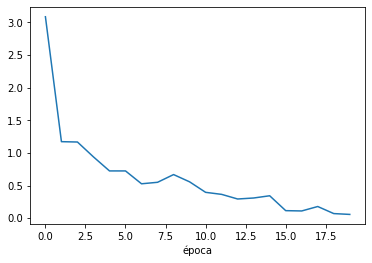

In [135]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [136]:
evaluation(model=model, loader=test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Accuracy: 0.7457000613212585


# Bonus Opcional

## Implementando o Dropout

In [ ]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        return out

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [ ]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)